In [6]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [7]:
# Create list of all targets (minus background noise)
dataset_path = '.\\data_speech_commands_v0.02'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [8]:
# Settings
feature_sets_path = '.\\'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'stop'

In [9]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [10]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [11]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77553, 16, 16)
(9658, 16, 16)
(9645, 16, 16)


In [12]:
# Peek at labels
print(y_val)

[21. 25. 22. ... 18. 23. 19.]


In [13]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [14]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 0.]


In [15]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.04069165458687099
0.959308345413129


In [16]:
# View the dimensions of our input data
print(x_train.shape)

(77553, 16, 16)


In [17]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77553, 16, 16, 1)
(9658, 16, 16, 1)
(9645, 16, 16, 1)


In [18]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [19]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0

In [21]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [22]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
776/776 [==============================] - 6s 6ms/step - loss: 0.1163 - acc: 0.9657 - val_loss: 0.1153 - val_acc: 0.9666
Epoch 2/30
776/776 [==============================] - 6s 8ms/step - loss: 0.0734 - acc: 0.9771 - val_loss: 0.0615 - val_acc: 0.9793
Epoch 3/30
776/776 [==============================] - 5s 7ms/step - loss: 0.0632 - acc: 0.9804 - val_loss: 0.0684 - val_acc: 0.9795
Epoch 4/30
776/776 [==============================] - 5s 7ms/step - loss: 0.0572 - acc: 0.9824 - val_loss: 0.0569 - val_acc: 0.9817
Epoch 5/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0530 - acc: 0.9836 - val_loss: 0.0711 - val_acc: 0.9813
Epoch 6/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0523 - acc: 0.9849 - val_loss: 0.0578 - val_acc: 0.9837
Epoch 7/30
776/776 [==============================] - 5s 7ms/step - loss: 0.0507 - acc: 0.9852 - val_loss: 0.0528 - val_acc: 0.9845
Epoch 8/30
776/776 [==============================] - 5s 6ms/step - loss: 0.

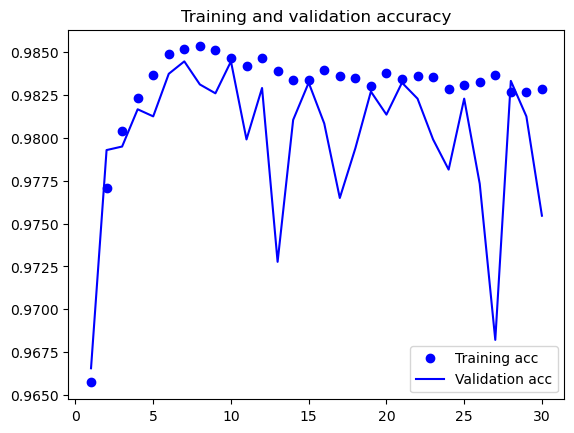

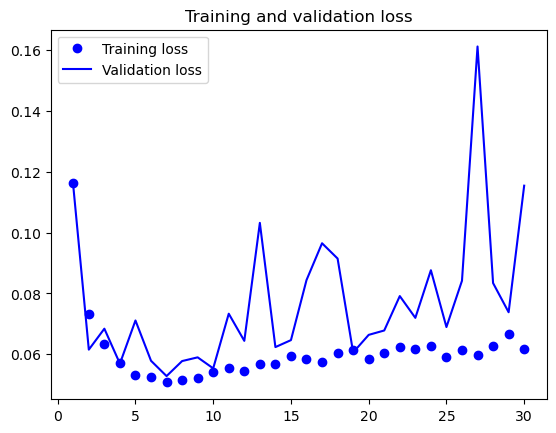

In [23]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
# Save the model as a file
models.save_model(model, model_filename)

In [25]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

14
45
51
68
89
110
114
237
312
342
349
357
360
375
381
422
443
458
468
494
534
653
657
662
673
681
683
697
728
788
893
921
923
931
938
947
950
1018
1024
1026
1039
1064
1172
1175
1177
1217
1251
1264
1339
1342
1424
1445
1564
1591
1618
1626
1628
1643
1654
1713
1715
1730
1744
1766
1800
1882
1908
1969
1974
2010
2029
2115
2138
2163
2195
2199
2212
2231
2243
2281
2342
2370
2375
2380
2390
2426
2448
2485
2510
2562
2579
2651
2652
2657
2669
2706
2738
2744
2785
2830
2834
2840
2942
2982
2993
3024
3060
3137
3174
3210
3211
3273
3279
3307
3309
3315
3374
3383
3404
3427
3455
3469
3519
3541
3577
3604
3636
3668
3688
3721
3733
3747
3795
3797
3798
3807
3842
3868
3943
3984
4048
4069
4129
4152
4207
4222
4236
4245
4257
4269
4316
4400
4415
4460
4465
4473
4518
4568
4617
4635
4658
4666
4683
4800
4802
4817
4837
4848
4880
4964
4985
4991
5045
5049
5101
5132
5133
5145
5147
5248
5269
5275
5302
5349
5354
5391
5395
5417
5454
5465
5496
5514
5532
5566
5581
5588
5591
5630
5658
5664
5669
5720
5746
5766
5798
5812
5819
5821
58

In [26]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

1/1 [==============================] - 0s 94ms/step
Answer: 0.0  Prediction: [[2.3452426e-14]]
1/1 [==============================] - 0s 27ms/step
Answer: 0.0  Prediction: [[0.00016795]]
1/1 [==============================] - 0s 16ms/step
Answer: 0.0  Prediction: [[3.2811628e-23]]
1/1 [==============================] - 0s 18ms/step
Answer: 0.0  Prediction: [[0.00080078]]
1/1 [==============================] - 0s 27ms/step
Answer: 0.0  Prediction: [[0.06490036]]
1/1 [==============================] - 0s 18ms/step
Answer: 0.0  Prediction: [[0.0007833]]
1/1 [==============================] - 0s 14ms/step
Answer: 0.0  Prediction: [[0.00174119]]
1/1 [==============================] - 0s 32ms/step
Answer: 0.0  Prediction: [[0.00018378]]
1/1 [==============================] - 0s 18ms/step
Answer: 0.0  Prediction: [[7.888526e-06]]
1/1 [==============================] - 0s 18ms/step
Answer: 0.0  Prediction: [[1.4581866e-07]]


In [27]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

302/302 [==============================] - 1s 2ms/step - loss: 0.1035 - acc: 0.9762


[0.10346902161836624, 0.9761534333229065]